In [1]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics

In [2]:
# #############################################################################
# Get data
from superdarn_cluster.dbtools import flatten_data_11_features, read_db
import datetime as dt

start_time = dt.datetime(2018, 2, 7, 12)
end_time = dt.datetime(2018, 2, 7, 20)
rad = 'sas'
db_path = "./Data/sas_GSoC_2018-02-07.db"
b = 0
data_dict = read_db(db_path, rad, start_time, end_time)
data_flat_unscaled = flatten_data_11_features(data_dict, remove_close_range=True)

In [3]:
import sklearn
sklearn.__version__

'0.19.1'

In [4]:

import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
feature_names = ['beam', 'gate', 'vel', 'wid', 'power', 'freq', 'time', 'phi0', 'elev', 'nsky', 'nsch']

gate = data_flat_unscaled[:, 1]
power = data_flat_unscaled[:, 4]
beam = data_flat_unscaled[:, 0]
vel = data_flat_unscaled[:, 2]
wid = data_flat_unscaled[:, 3]
time = data_flat_unscaled[:, 6]
#time = (time - np.floor(time)) * 24 * 60 * 60 / secs_per_measurement

In [5]:
# What matters for scaling this is the size of each step between these (discrete) measurements.
# If you want to connect things within 1 range gate and 1 beam, do no scaling and set eps ~= 1.1
# If you want to connect things within 6 time measurements, scale it so that 6 * dt = 1 and eps ~= 1.1
# Time has some gaps in between each scan of 16 beams, so epsilon should be large enough
scaled_time = (time - time[0]) * 0.000467 #(time - np.floor(time)) * 24 * 60 * 60 
uniq_time = np.sort(np.unique(scaled_time))
shifted_time = np.roll(uniq_time, -1)
dt = np.min((shifted_time - uniq_time)[:-1])
integer_time = scaled_time / dt
scaled_time = scale(scaled_time / (dt))
print(dt)
# Divide by variance and center mean at 0
scaled_gate = gate
scaled_beam = beam

sorted_time = np.sort(np.unique(scaled_time))[:20]
print(sorted_time[0] - sorted_time[1])

sorted_gate = np.sort(np.unique(scaled_gate))[:10]
print(sorted_gate[0] - sorted_gate[1])

sorted_beam = np.sort(np.unique(scaled_beam))[:10]
print(sorted_beam[0] - sorted_beam[1])


1.5442323405298695e-08
-0.0004671592970142413
-1.0
-1.0


In [6]:
# ~~ DBSCAN ~~
time_eps = 50.0
beam_eps = 2.0
gate_eps = 3.0

X = np.column_stack((beam / beam_eps, gate / gate_eps, integer_time / time_eps))
print(X.shape)

eps, minPts = 1, 15
# NOTE - this will run extremely slow on certain computers due to high memory consumption.
# It has done this on an Ubuntu 16 computer with a HDD and 8GB memory   (my suspicion is, slow swap-space access)
# It has worked fine on an Ubuntu 18 laptop with a SSD and 8GB memory 
db = DBSCAN(eps=eps, min_samples=minPts).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)
print(labels[:100])

(71649, 3)


Estimated number of clusters: 39
[-1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  0  0  0  0
  0  0  0  0  0  0  0  0  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0 -1 -1 -1  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0
  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  0  0  0  0  0  0
  0  0  0  0]


In [7]:
print(labels.shape)
print(core_samples_mask.shape)
print(X.shape)

(71649,)
(71649,)
(71649, 3)


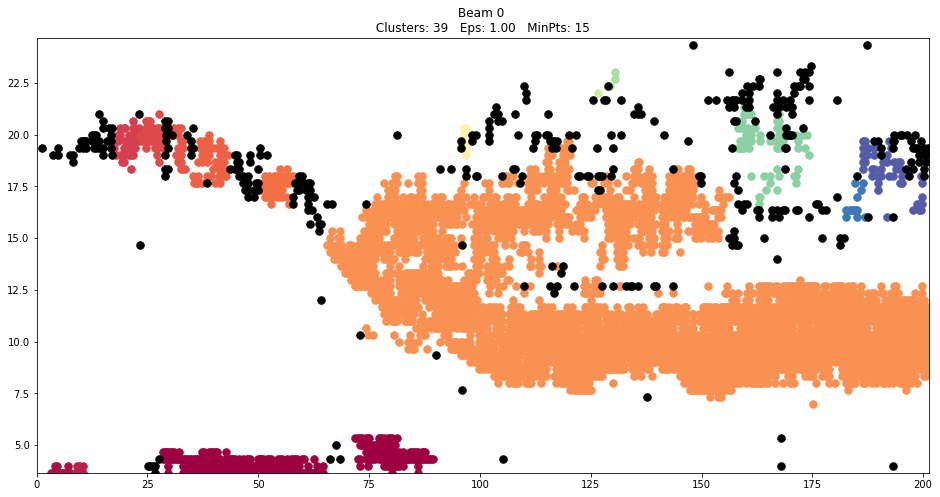

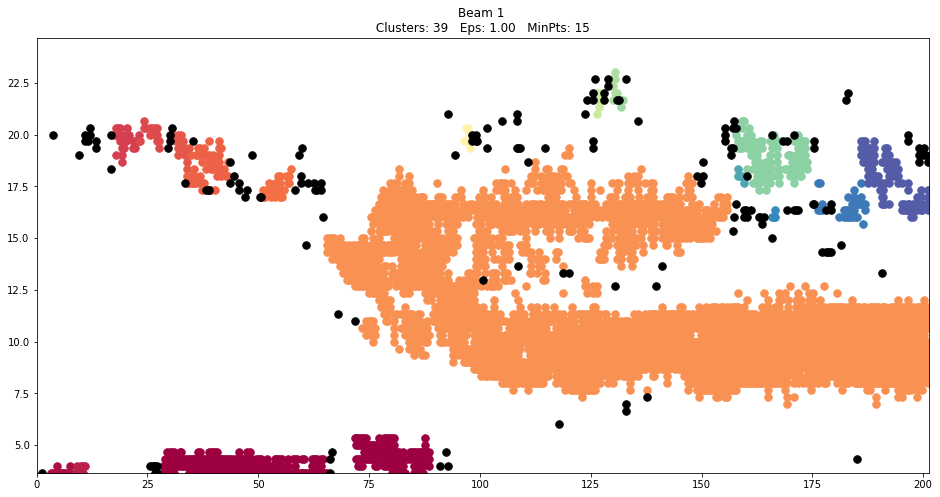

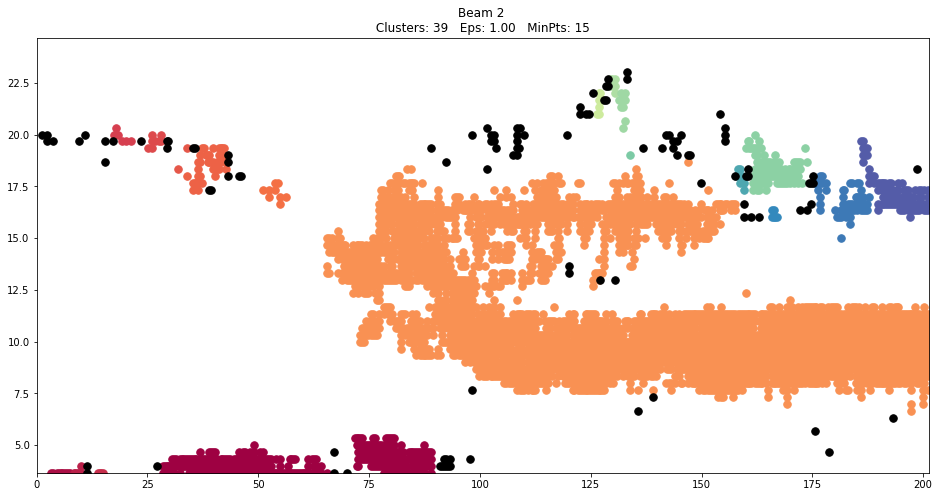

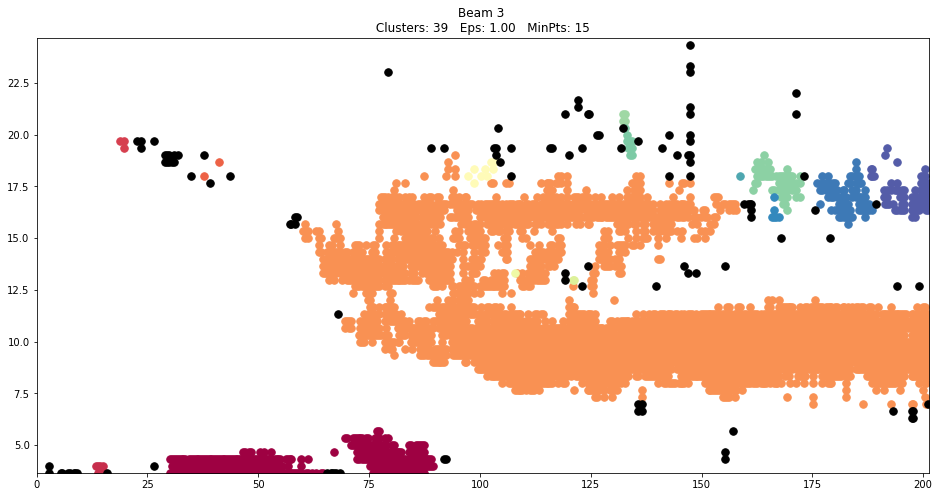

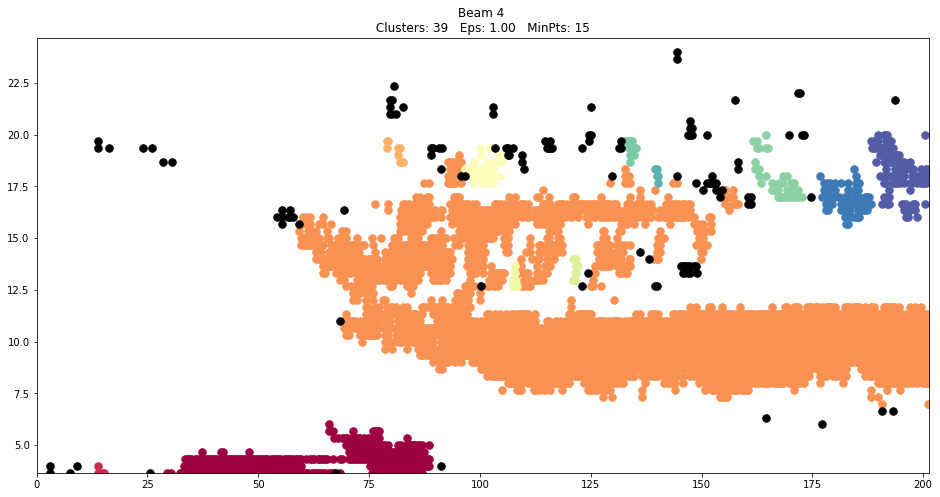

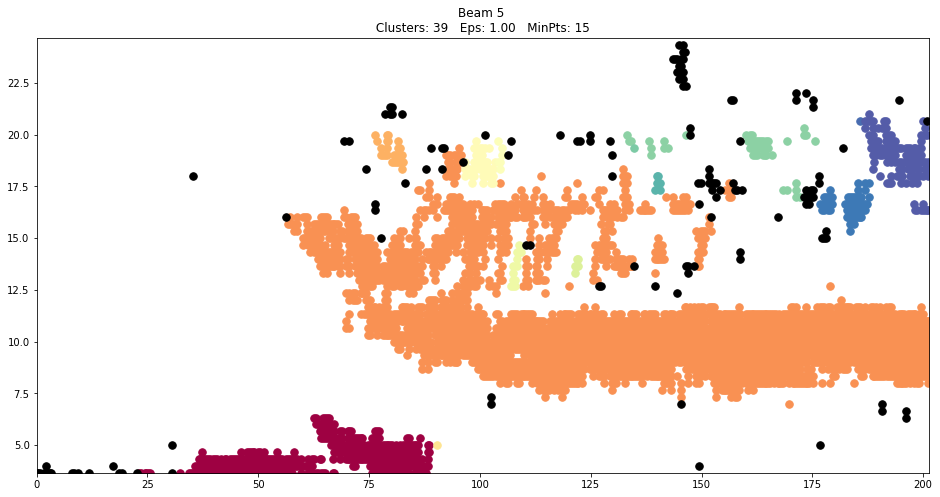

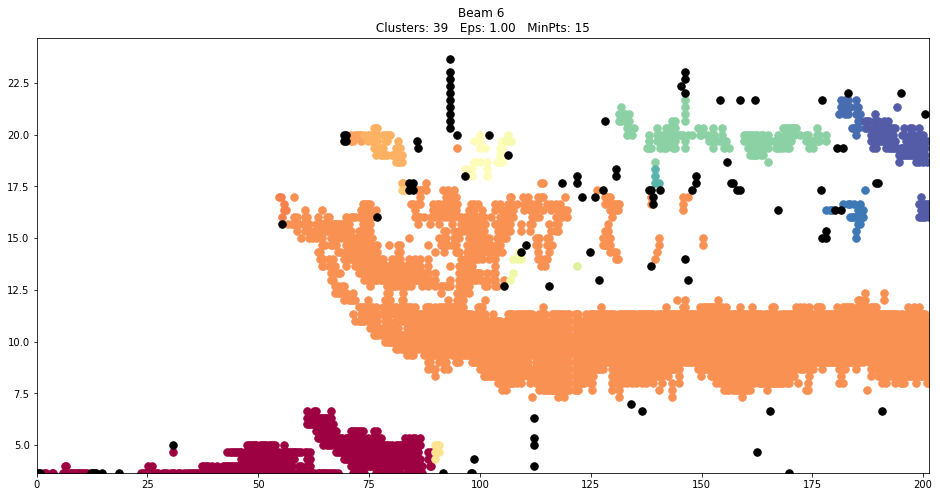

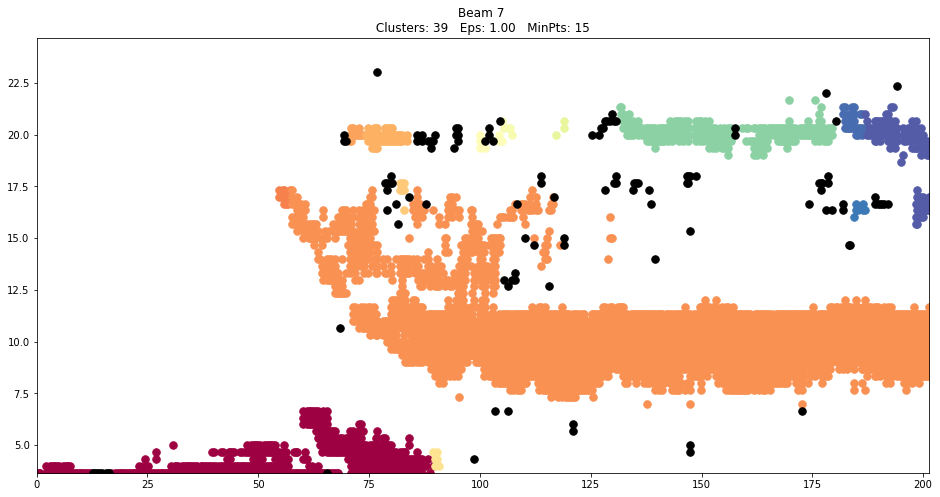

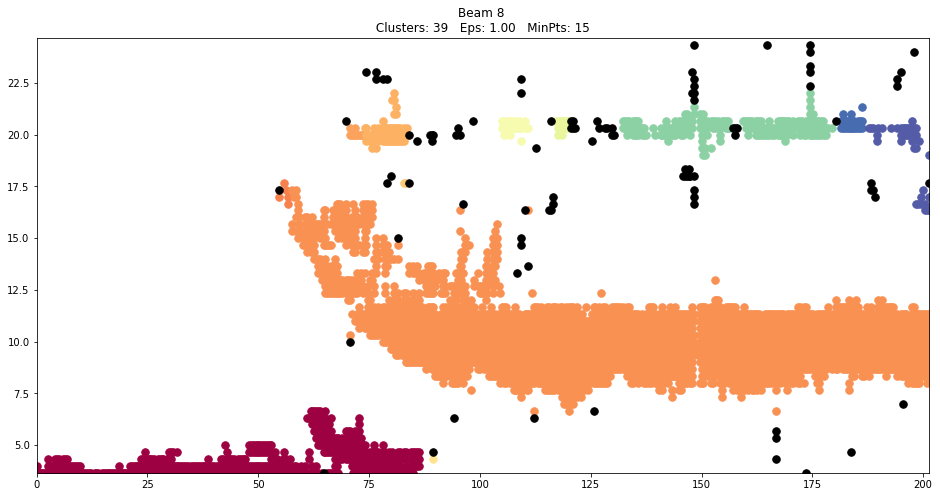

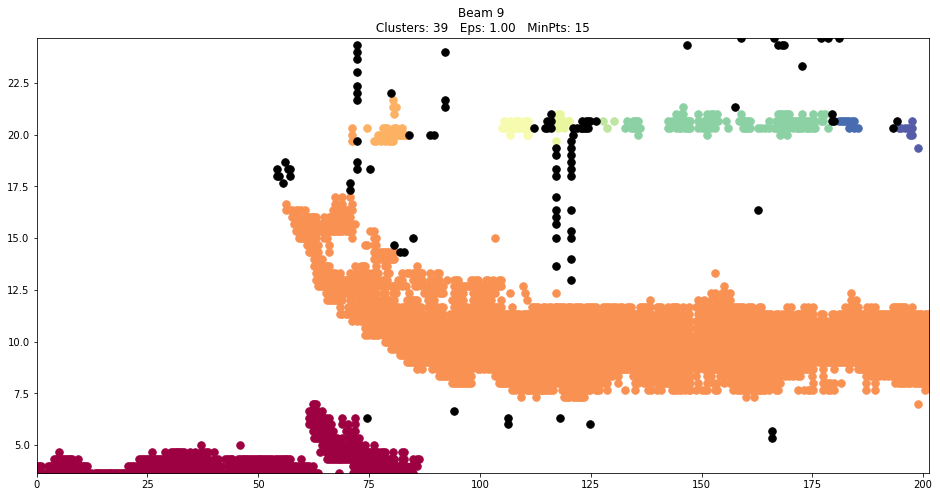

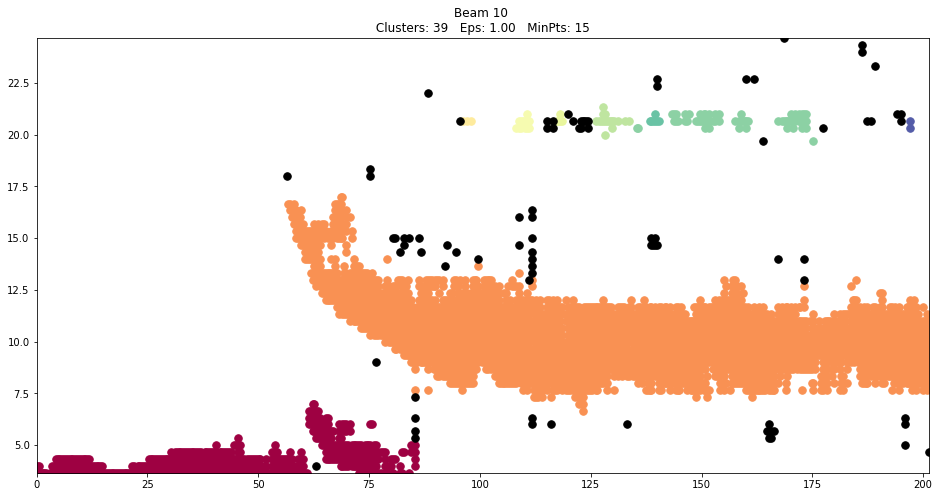

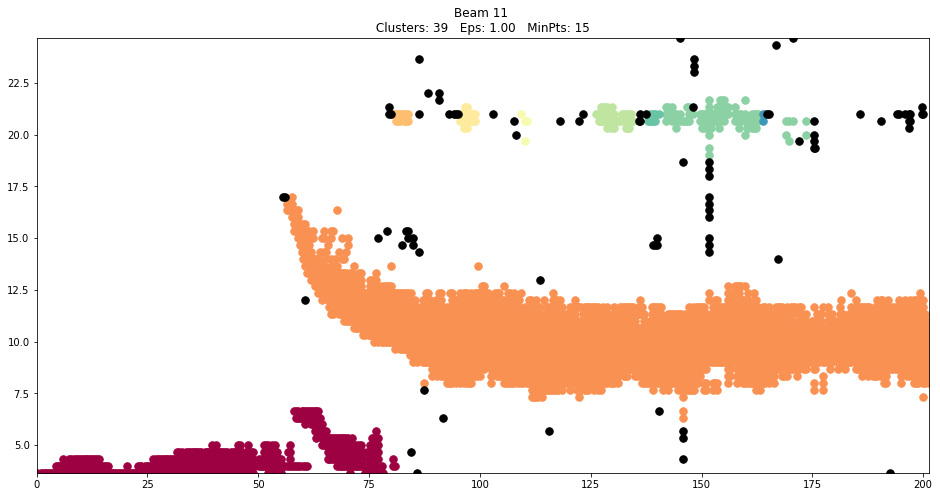

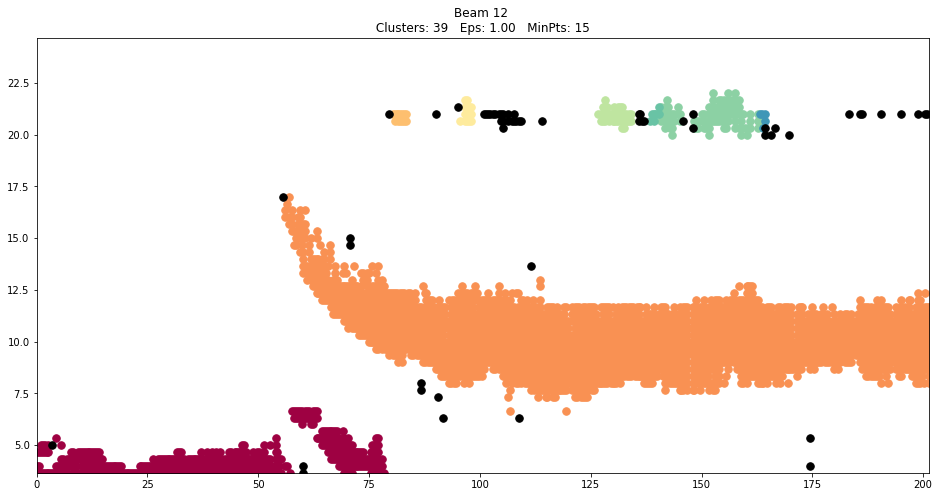

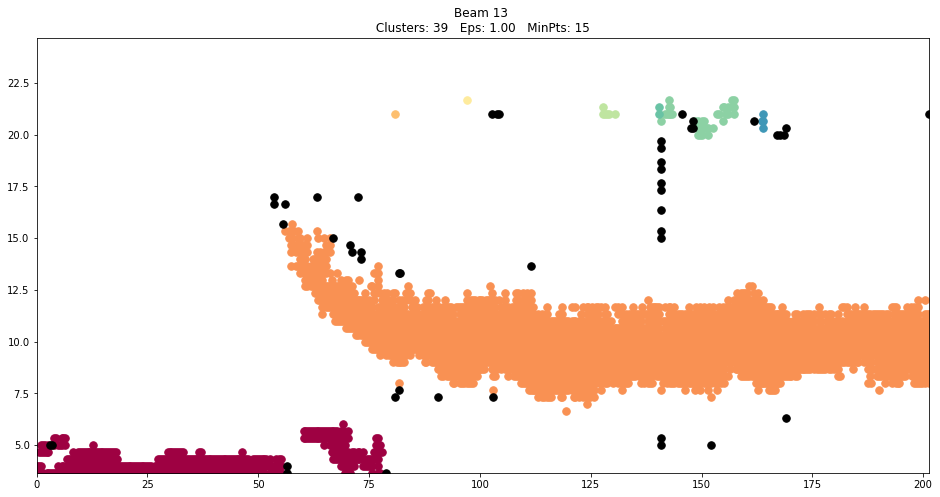

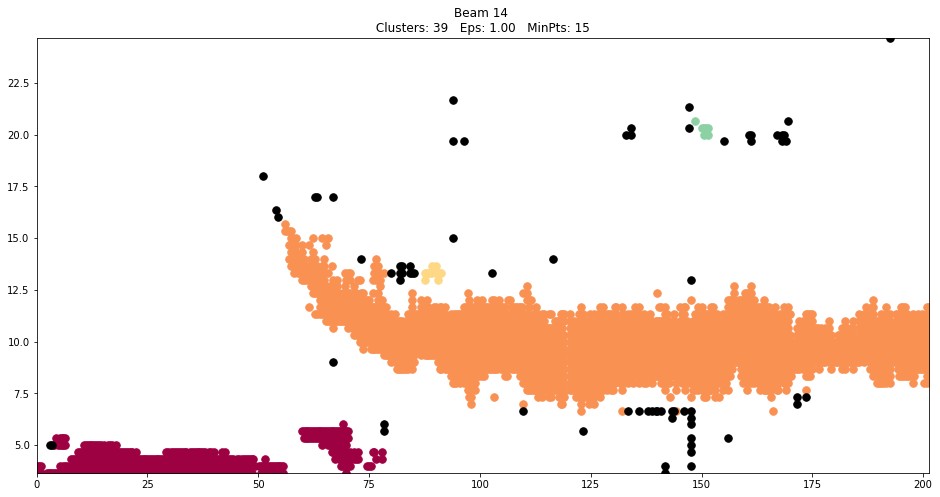

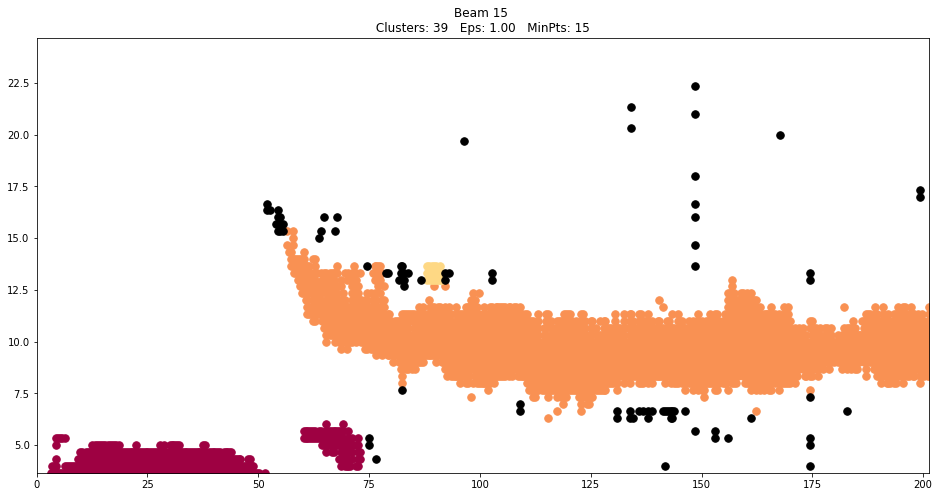

In [8]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
range_max = data_dict['nrang'][0]

for b in range(16):
    fig = plt.figure(figsize=(16,8))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)
        beam_mask = (beam == b)

        xy = X[class_member_mask & core_samples_mask & beam_mask]
        plt.plot(xy[:, 2], xy[:, 1], '.', color=tuple(col), markersize=15)

        xy = X[class_member_mask & ~core_samples_mask & beam_mask]
        plt.plot(xy[:, 2], xy[:, 1], '.', color=tuple(col), markersize=15)

    plt.xlim((np.min(integer_time/time_eps), np.max(integer_time/time_eps)))
    plt.ylim((np.min(gate/gate_eps), np.max(gate/gate_eps)))
    plt.title('Beam %d \n Clusters: %d   Eps: %.2f   MinPts: %d ' % (b, n_clusters_, eps, minPts))
    plt.savefig('dbscan beam ' + str(b))

In [9]:
from superdarn_cluster.utilities import plot_clusters

stats_i = [0, 1, 2, 3, 4, 7, 8]
data_flat_unscaled[:, 2] = np.abs(data_flat_unscaled[:, 2])
data_flat_unscaled[:, 2] = np.abs(data_flat_unscaled[:, 2])

plot_clusters(labels, data_flat_unscaled[:, stats_i], data_flat_unscaled[:, 6], 
               gate, vel, np.array(feature_names)[stats_i], range_max, start_time, end_time, save=True, base_path='dbscan ')

In [12]:
from sklearn.mixture import BayesianGaussianMixture
from superdarn_cluster.utilities import plot_clusters
gmm_data = np.column_stack((vel, wid, time, gate, beam))

def get_gs_flg(v, w):
    med_vel = np.median(np.abs(vel[class_member_mask]))
    med_wid = np.median(np.abs(wid[class_member_mask]))
    return med_vel < 30.0 - med_wid * 1.0 / 3.0

stats_i = [0, 1, 2, 3, 4, 7, 8]
gs_flg = np.zeros(len(time))

for k in unique_labels:
    class_member_mask = (labels == k)
    if np.sum(class_member_mask) < 500:
        gs_flg[class_member_mask] = get_gs_flg(vel[class_member_mask], wid[class_member_mask])
    
    data = gmm_data[class_member_mask]
    estimator = BayesianGaussianMixture(n_components=3,
                                        covariance_type='full', max_iter=500,
                                        random_state=0, n_init=5, init_params='kmeans',
                                        weight_concentration_prior=1,
                                        weight_concentration_prior_type='dirichlet_process')
    estimator.fit(data)
    clust_labels = estimator.predict(data)
    
    for cl in np.unique(clust_labels):
        cluster_mask = clust_labels == cl
        gs_flg[class_member_mask][cluster_mask] = get_gs_flg(data[cluster_mask, 0], data[cluster_mask, 1])
    
    data_for_stats = data_flat_unscaled[class_member_mask]
    data_for_stats = data_for_stats[:, stats_i]
    clust_time = time[class_member_mask]
    clust_gate = gate[class_member_mask]
    clust_vel = vel[class_member_mask]
    names_for_stats = np.array(feature_names)[stats_i]
    
    plot_clusters(clust_labels, data_for_stats, clust_time, clust_gate, clust_vel, names_for_stats, range_max, start_time, end_time, 
                  save=True, base_path='gmm dbscan cluster ' + str(k) + " ")
    
    


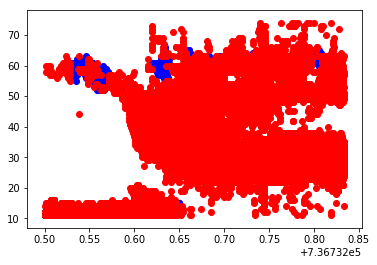

In [13]:
plt.scatter(time[gs_flg == 1], gate[gs_flg == 1], color='blue')
plt.scatter(time[gs_flg == 0], gate[gs_flg == 0], color='red')
plt.show()